# Housekeeping

## Library imports

In [1]:
if True:
    import sys
    !{sys.executable} -m pip install -r requirements.txt

In [2]:
# Core Libraries
import pandas as pd
import seaborn as sns
from colorama import Fore, Style
import warnings
import matplotlib.pyplot as plt
import numpy as np
import re

# Machine Learning - Core
import sklearn
import tensorflow as tf

# Statistical & Data Processing
from scipy import stats
from sklearn.model_selection import GroupShuffleSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Machine Learning - Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Model Interpretability
from sklearn.metrics import mean_squared_error, r2_score
from supertree import SuperTree

# Custom Functions
from functions import (
    random_forest_benchmark,
    xgboost_benchmark,
    adaboost_benchmark,
    gradient_boosting_benchmark,
    lightgbm_benchmark,
    nn_feature_search,
    explain_with_lime,
    explain_with_shap,
    cross_validate_feature_cutoffs,
    plot_feature_cutoff_comparison,
    plot_model_comparison_heatmap,
    plot_residuals_analysis,
    plot_prediction_intervals,
    plot_learning_curves,
    feature_selection_pipeline,
    final_battle
)

2026-01-22 16:38:14.781482: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-22 16:38:14.782023: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-22 16:38:14.830279: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-22 16:38:16.477124: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different compu

No GPU found. Running on CPU mode.


2026-01-22 16:38:17.428184: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Optional Imports (for specific analyses)

These imports are used for specific visualizations and analyses that may not be needed in every run.

In [3]:
# Optional: Advanced Visualizations
# from sklearn.decomposition import PCA
# from click.format import wrap_text  # May not be needed
# import collections  # Built-in, no install needed

# Note: Most visualization functions are now in functions.py
# and imported above in the main imports cell

## Settings

In [4]:
warnings.filterwarnings("ignore")
sklearn.set_config(transform_output="pandas")
print(Style.RESET_ALL)

gpus = tf.config.list_physical_devices('GPU')
if gpus or False: #<- Change to True if you want to torture your computer (:
    RUN_NN = True
    print("GPU found")
else:
    RUN_NN = False

## Data imports
Data was manually edited, to convert the mpa411.txt TSV format to a CSV format. Otherwise, Pandas was loading it as a single column, somehow. The first row, containing only "#mpa_vJun23_CHOCOPhlAnSGB_202403" was removed.

In [5]:
data = pd.read_csv('../data/raw/MAI3004_lucki_mpa411.csv')
metadata = pd.read_csv('../data/raw/MAI3004_lucki_metadata_safe.csv')
print(
    f"Data successfully imported. \n shape of data: {data.shape} \n "
    f"Shape of metadata: {metadata.shape}"
)

assert data.shape == (6903, 932), "Data has the wrong shape. Check the CSV formatting."
assert metadata.shape == (930, 6), "Metadata has the wrong shape. Check the CSV formatting."

Data successfully imported. 
 shape of data: (6903, 932) 
 Shape of metadata: (930, 6)


## Function definitions
| Function Name | Description | Parameters |
|---------------|-------------|------------|


# Data preprocessing

## Merge data and metadata

In [6]:
sample_cols = [col for col in data.columns if col.startswith("mpa411_")]

sample_abundances = (
    data[['clade_name'] + sample_cols]
    .set_index('clade_name')
    .transpose()
    .rename_axis('original_sample_id')
    .reset_index()
    .rename(columns={'original_sample_id': 'sample_id'})
)

sample_abundances["sample_id"] = (
    sample_abundances["sample_id"].str.removeprefix(
        "mpa411_",
    )
)

metadata_common = metadata[
    metadata["sample_id"].isin(sample_abundances["sample_id"])
].copy()
merged_samples = metadata_common.merge(
    sample_abundances,
    on="sample_id",
    how="inner",
)

merged_samples.drop(columns=['year_of_birth', 'body_product'], inplace=True)

print(f"Metadata rows (original): {metadata.shape[0]}")
print(f"Metadata rows with matching samples: {metadata_common.shape[0]}")
print(
    f"Metadata rows without matching samples: "
    f"{metadata_common.shape[0]-metadata_common.shape[0]}"
)
print(f"Merged dataframe shape: {merged_samples.shape}")

Metadata rows (original): 930
Metadata rows with matching samples: 930
Metadata rows without matching samples: 0
Merged dataframe shape: (930, 6907)


In [7]:
merged_samples.head()

,sample_id,family_id,sex,age_group_at_sample,UNCLASSIFIED,k__Bacteria,k__Bacteria|p__Actinobacteria,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Candidatus_Saccharibacteria,...,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03|t__SGB4260,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033|t__SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061|t__SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528|t__SGB6528
0,MMHP_Lucki_0001,ENA_fam_0139,female,1-2 weeks,11.15024,88.849765,51.309655,0.002106,34.721253,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MMHP_Lucki_0002,ENA_fam_0139,female,NaN,13.65529,86.284502,4.551376,0.041143,71.819009,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MMHP_Lucki_0003,ENA_fam_0136,female,1-2 weeks,20.33656,79.663440,64.794124,10.664824,0.526129,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MMHP_Lucki_0004,ENA_fam_0136,female,NaN,11.30536,88.694643,11.944587,0.284914,73.876500,0.00259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MMHP_Lucki_0005,ENA_fam_0136,female,4 weeks,21.67587,78.324133,57.245464,18.558613,0.918946,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Encoding

In [8]:
# Sex and family_ID
encoded_samples = merged_samples.copy().dropna(subset="age_group_at_sample")

encoded_samples["sex"] = (
    encoded_samples["sex"]
    .fillna("unknown")
    .replace({"female": 1, "male": 0, "unknown": 2})
)
encoded_samples["family_id"] = LabelEncoder().fit_transform(
    encoded_samples["family_id"]
)

In [70]:
#Using days to better interpret the distance between age groups
encoding_guide = {
    '1-2 weeks': 10,
    '4 weeks': 28,
    '8 weeks': 56,
    '4 months': 120,
    '5 months': 150,
    '6 months': 180,
    '9 months': 270,
    '11 months': 330,
    '14 months': 420,
}
encoded_samples["age_group_at_sample"] = encoded_samples["age_group_at_sample"].replace(encoding_guide)
encoded_samples["age_group_at_sample"] = encoded_samples["age_group_at_sample"].astype(int)
# consider in interpretation that the distances between the real age bins are not the same as our age groups

In [71]:
leftovers = encoded_samples[encoded_samples["age_group_at_sample"].apply(lambda x: isinstance(x, str))]

if not leftovers.empty:

    print("Age group encoding:", leftovers["age_group_at_sample"].unique())

else:
    print("Fallback encoding not needed")


Fallback encoding not needed


## Missing check

In [72]:
missing_table = (
    encoded_samples.isna()
    .sum()
    .to_frame(name="missing_count")
    .assign(
        missing_percent=lambda df: (
            (df["missing_count"] / encoded_samples.shape[0] * 100).round(2)
        ),
    )
    .reset_index()
    .rename(columns={"index": "column"})
    .sort_values("missing_count", ascending=False)
    .query("missing_count != 0")
)

if len(missing_table) > 0:
    missing_table
else:
    print("No missing values detected.")

No missing values detected.


## Outlier check

In [73]:
numeric_cols = encoded_samples.select_dtypes(include=[np.number]).columns

q1 = encoded_samples[numeric_cols].quantile(0.25)
q3 = encoded_samples[numeric_cols].quantile(0.75)
iqr = q3 - q1

lower_bounds = q1 - 1.5 * iqr
upper_bounds = q3 + 1.5 * iqr

outlier_mask = (
    (encoded_samples[numeric_cols] < lower_bounds)
    | (encoded_samples[numeric_cols] > upper_bounds)
)
outlier_counts = outlier_mask.sum()
outlier_percent = (outlier_counts / encoded_samples.shape[0] * 100).round(2)

outlier_table = (
    pd.DataFrame({
        "column": numeric_cols,
        "lower_bound": lower_bounds,
        "upper_bound": upper_bounds,
        "outlier_count": outlier_counts,
        "outlier_percent": outlier_percent,
    })
    .query("outlier_count > 0")
    .sort_values("outlier_percent", ascending=False)
    .reset_index(drop=True)
)

outlier_table

,column,lower_bound,upper_bound,outlier_count,outlier_percent
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,0.000000,0.000000,201,24.88
1,k__Bacteria|p__Actinobacteria|c__Actinomycetia...,0.000000,0.000000,201,24.88
2,k__Bacteria|p__Verrucomicrobia,-0.000195,0.000325,200,24.75
3,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacill...,0.000000,0.000000,198,24.50
4,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,0.000000,0.000000,198,24.50
...,...,...,...,...,...
5155,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,0.000000,0.000000,1,0.12
5156,k__Bacteria|p__Firmicutes|c__CFGB1374|o__OFGB1...,0.000000,0.000000,1,0.12
5157,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,0.000000,0.000000,1,0.12
5158,k__Bacteria|p__Firmicutes|c__CFGB1425|o__OFGB1...,0.000000,0.000000,1,0.12


## Normalisation check

In [74]:
normalized_samples = encoded_samples.copy()
print("Shapiro-Wilk Normality Test")

for column in numeric_cols:
    data_nona = normalized_samples[column].dropna()
    stat, p_value = stats.shapiro(data_nona)

    if p_value > 0.05:
        print(Fore.GREEN + f"{column}: Normally Distributed (p={p_value:.4f})")

    else:
        print(
            Fore.RED
            + f"{column}: Not Normally Distributed (p={p_value:.4f})"
        )

print(Style.RESET_ALL)

Shapiro-Wilk Normality Test
family_id: Not Normally Distributed (p=0.0000)
age_group_at_sample: Not Normally Distributed (p=0.0000)
UNCLASSIFIED: Not Normally Distributed (p=0.0000)
k__Bacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Actinobacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Proteobacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Candidatus_Saccharibacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Bacteroidota: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Actinobacteria|c__Actinomycetia: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes|c__Negativicutes: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes|c__Clostridia: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes|c__Bacilli: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Actinob

## Train-test split before pre-processing

In [75]:
feature_cols = normalized_samples.columns.difference(["sample_id", "age_group_at_sample"]) # These variables will get removed from X

X = normalized_samples[feature_cols]
Y = normalized_samples["age_group_at_sample"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=3004)
train_indicies, test_indicies = next(gss.split(X, Y, groups=X['family_id']))
X_train_raw = X.iloc[train_indicies]
X_test_raw = X.iloc[test_indicies]
Y_train = Y.iloc[train_indicies]
Y_test = Y.iloc[test_indicies]

assert X_train_raw.shape[1] == X_test_raw.shape[1], "Feature columns do not match between train and test sets."
assert X_train_raw.shape[0] == Y_train.shape[0] and X_test_raw.shape[0] == Y_test.shape[0], "X and Y do not have the same length."

print("Train shape:", X_train_raw.shape, "| Test shape:", X_test_raw.shape)

Train shape: (628, 6905) | Test shape: (180, 6905)


## Normalising data using clr transformation

In [76]:
"""The CLR function based on: https://medium.com/@nextgendatascientist/a-guide-for-data-scientists-log-ratio-transformations-in-machine-learning-a2db44e2a455"""

def clr_transform(X, epsilon=1e-9):
    """
    Compute CLR with a tunable zero-replacement value (epsilon).
    """

    #To capture metadata from the original dataframe
    if isinstance(X, pd.DataFrame):
        index = X.index
        columns = X.columns
        X_arr = X.values.astype(float)
    else:
        X_arr = np.array(X).astype(float)

    # 1. Replace zeros with epsilon (tunable parameter)
    X_replaced = np.where(X_arr == 0, epsilon, X_arr)

    # 2. Compute Geometric Mean
    # exp(mean(log)) is safer and standard for this
    gm = np.exp(np.log(X_replaced).mean(axis=1, keepdims=True))

    # 3. CLR transformation
    X_clr = np.log(X_replaced / gm)


    #Rebulding back a NumPy array to a dataframe
    if isinstance(X, pd.DataFrame):
        return pd.DataFrame(X_clr, index=index, columns=columns)

    return X_clr

In [77]:
X_train = clr_transform(X_train_raw)
X_test = clr_transform(X_test_raw)

In [78]:
#To activate back the raw data without normalisation

#X_train = X_train_raw
#X_test = X_test_raw

In [79]:
print("Shapiro-Wilk Normality Test (after Log Normlaisation)\n")

for col in X_train.columns:

    # 1. Get the data for this column from both sets
    train_data = X_train[col].dropna()
    test_data = X_test[col].dropna()

    # 2. Run Shapiro test on both
    stat_train, p_train = stats.shapiro(train_data)
    stat_test, p_test = stats.shapiro(test_data)

    # 3. Determine status (Both must be > 0.05 to be truly "Normal")
    is_train_normal = p_train > 0.05
    is_test_normal = p_test > 0.05

    # 4. Print Logic
    # If both are Green
    if is_train_normal and is_test_normal:
        print(Fore.GREEN + f"✔ {col}: Normal (Train p={p_train:.3f}, Test p={p_test:.3f})")

    # If one is Red (Mixed results)
    elif is_train_normal or is_test_normal:
        print(Fore.YELLOW + f"⚠ {col}: Inconsistent (Train p={p_train:.3f}, Test p={p_test:.3f})")

    # If both are Red
    else:
        print(Fore.RED + f"✘ {col}: Not Normal (Train p={p_train:.3f}, Test p={p_test:.3f})")

print(Style.RESET_ALL)

Shapiro-Wilk Normality Test (after Log Normlaisation)

✘ UNCLASSIFIED: Not Normal (Train p=0.000, Test p=0.000)
✘ family_id: Not Normal (Train p=0.000, Test p=0.000)
✘ k__Archaea: Not Normal (Train p=0.000, Test p=0.000)
✘ k__Archaea|p__Candidatus_Thermoplasmatota: Not Normal (Train p=0.000, Test p=0.000)
✘ k__Archaea|p__Candidatus_Thermoplasmatota|c__Thermoplasmata: Not Normal (Train p=0.000, Test p=0.000)
✘ k__Archaea|p__Candidatus_Thermoplasmatota|c__Thermoplasmata|o__Methanomassiliicoccales: Not Normal (Train p=0.000, Test p=0.000)
✘ k__Archaea|p__Candidatus_Thermoplasmatota|c__Thermoplasmata|o__Methanomassiliicoccales|f__Candidatus_Methanomethylophilaceae: Not Normal (Train p=0.000, Test p=0.000)
✘ k__Archaea|p__Candidatus_Thermoplasmatota|c__Thermoplasmata|o__Methanomassiliicoccales|f__Candidatus_Methanomethylophilaceae|g__Candidatus_Methanomethylophilus: Not Normal (Train p=0.000, Test p=0.000)
✘ k__Archaea|p__Candidatus_Thermoplasmatota|c__Thermoplasmata|o__Methanomassiliicocca

# Exploratory data analysis

In [80]:
print(merged_samples.shape)
merged_samples.head()

(930, 6907)


,sample_id,family_id,sex,age_group_at_sample,UNCLASSIFIED,k__Bacteria,k__Bacteria|p__Actinobacteria,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Candidatus_Saccharibacteria,...,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03|t__SGB4260,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033|t__SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061|t__SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528|t__SGB6528
0,MMHP_Lucki_0001,ENA_fam_0139,female,1-2 weeks,11.15024,88.849765,51.309655,0.002106,34.721253,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MMHP_Lucki_0002,ENA_fam_0139,female,NaN,13.65529,86.284502,4.551376,0.041143,71.819009,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MMHP_Lucki_0003,ENA_fam_0136,female,1-2 weeks,20.33656,79.663440,64.794124,10.664824,0.526129,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MMHP_Lucki_0004,ENA_fam_0136,female,NaN,11.30536,88.694643,11.944587,0.284914,73.876500,0.00259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MMHP_Lucki_0005,ENA_fam_0136,female,4 weeks,21.67587,78.324133,57.245464,18.558613,0.918946,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# Dataset overview
print("Number of samples:", len(merged_samples))
print(
    "Number of unique families (family_id):",
    merged_samples["family_id"].nunique(),
)
print("Number of columns (metadata + features):", merged_samples.shape[1])

Number of samples: 930
Number of unique families (family_id): 139
Number of columns (metadata + features): 6907


In [82]:
# Samples per family
samples_per_family = merged_samples["family_id"].value_counts()
samples_per_family.describe()

count    139.000000
mean       6.690647
std        2.232335
min        1.000000
25%        5.500000
50%        7.000000
75%        8.000000
max       11.000000
Name: count, dtype: float64

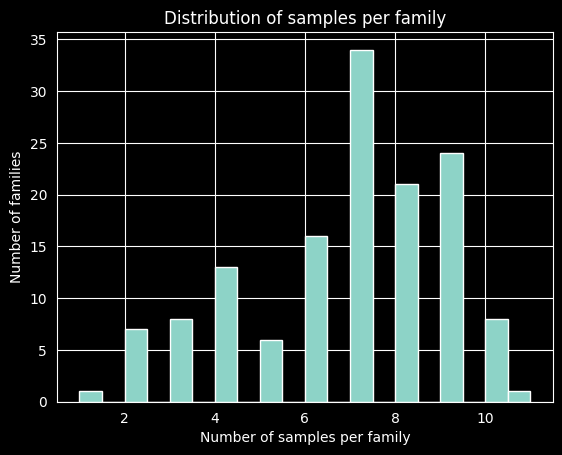

In [83]:
samples_per_family.hist(bins=20)
plt.xlabel("Number of samples per family")
plt.ylabel("Number of families")
plt.title("Distribution of samples per family")
plt.show()

In [84]:
#distribution of age groups
merged_samples["age_group_at_sample"].value_counts(dropna=False)

age_group_at_sample
NaN          122
8 weeks      105
4 months     103
5 months      96
9 months      92
6 months      88
1-2 weeks     84
11 months     83
4 weeks       82
14 months     75
Name: count, dtype: int64

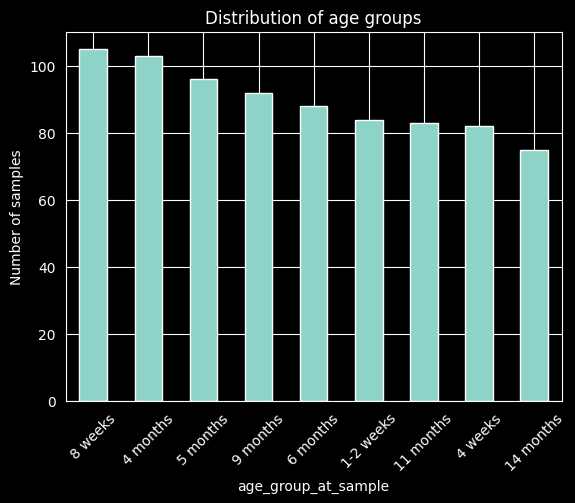

In [85]:
merged_samples["age_group_at_sample"].value_counts().plot(kind="bar")
plt.title("Distribution of age groups")
plt.ylabel("Number of samples")
plt.xticks(rotation=45)
plt.show()

In [86]:
#dimensionality and sparsity of the microbiome feature matrix
metadata_cols = [
    "sample_id",
    "family_id",
    "sex",
    "body_product",
    "age_group_at_sample",
    "year_of_birth",
]
feature_cols = [c for c in merged_samples.columns if c not in metadata_cols]

X = merged_samples[feature_cols]

print("Feature matrix shape:", X.shape)
print("Overall fraction of zeros:", (X == 0).mean().mean())

Feature matrix shape: (930, 6903)
Overall fraction of zeros: 0.9556136571445484


In [87]:
#number of observed taxa per sample
nonzero_per_sample = (X > 0).sum(axis=1)
nonzero_per_sample.describe()

count     930.000000
mean      306.398925
std       338.629879
min        46.000000
25%       127.000000
50%       181.000000
75%       282.000000
max      1821.000000
dtype: float64

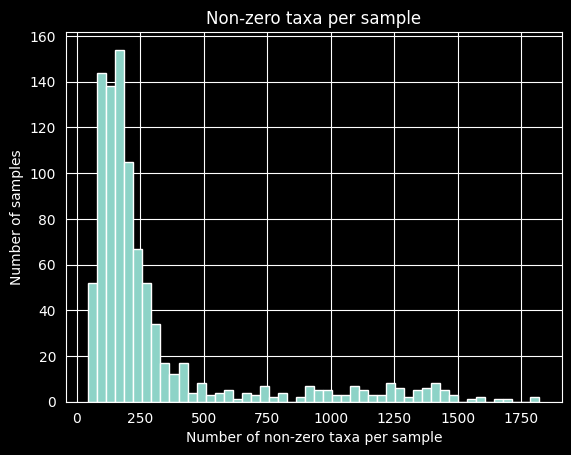

In [88]:
nonzero_per_sample.hist(bins=50)
plt.xlabel("Number of non-zero taxa per sample")
plt.ylabel("Number of samples")
plt.title("Non-zero taxa per sample")
plt.show()

In [89]:
# Total abundance per sample (sanity check)
total_abundance = X.sum(axis=1)
total_abundance.describe()

count    930.000000
mean     704.546050
std       64.838116
min      337.616534
25%      676.683539
50%      715.251764
75%      749.225950
max      800.000170
dtype: float64

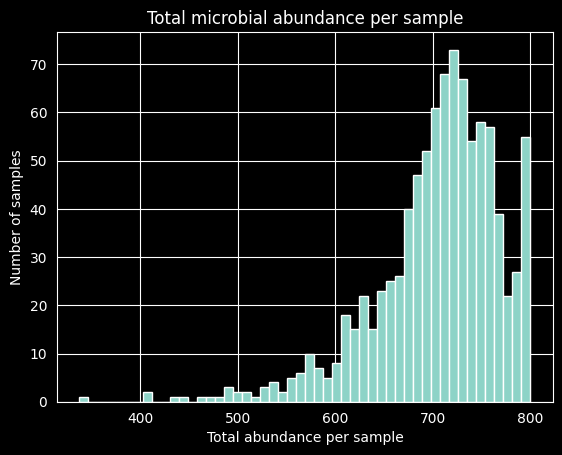

In [90]:
total_abundance.hist(bins=50)
plt.xlabel("Total abundance per sample")
plt.ylabel("Number of samples")
plt.title("Total microbial abundance per sample")
plt.show()

In [91]:
# Distribution of feature prevalence
feature_prevalence = (X > 0).sum(axis=0)
feature_prevalence.describe()

count    6903.000000
mean       41.279299
std        96.983595
min         1.000000
25%         2.000000
50%         9.000000
75%        38.000000
max       930.000000
dtype: float64

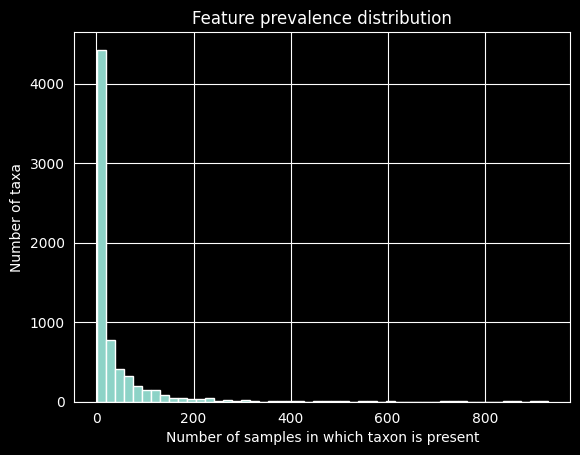

In [92]:
feature_prevalence.hist(bins=50)
plt.xlabel("Number of samples in which taxon is present")
plt.ylabel("Number of taxa")
plt.title("Feature prevalence distribution")
plt.show()

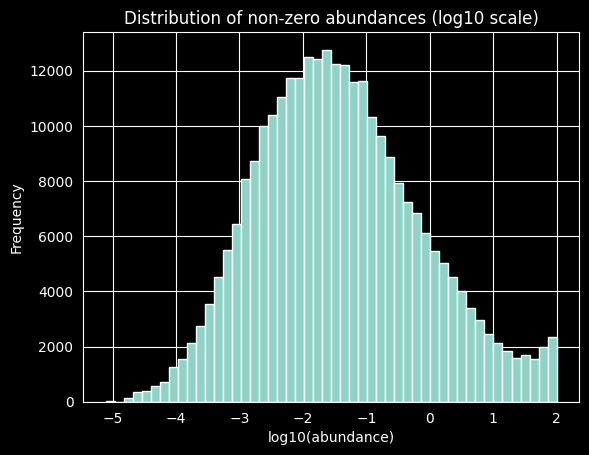

In [93]:
# Distribution of non-zero abundances (log scale)

nonzero_values = X.values[X.values > 0]
plt.hist(np.log10(nonzero_values), bins=50)
plt.xlabel("log10(abundance)")
plt.ylabel("Frequency")
plt.title("Distribution of non-zero abundances (log10 scale)")
plt.show()

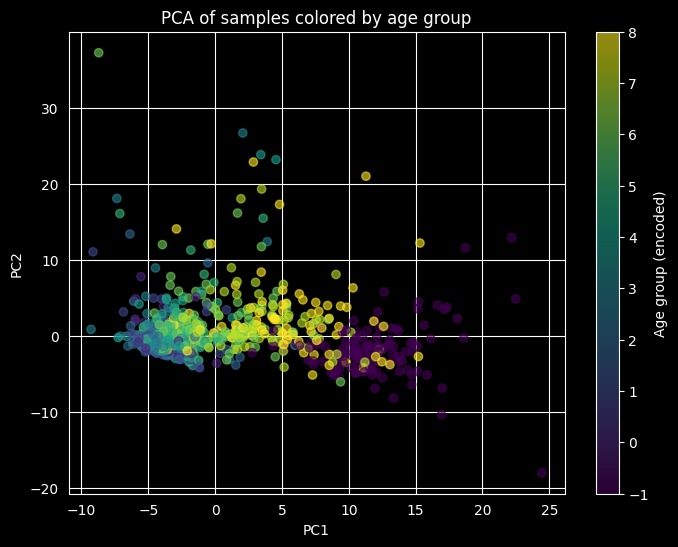

Explained variance ratio: [0.07115835 0.02969289]


In [94]:
# PCA visualization
# Use a subset of features for speed
prevalence = (X > 0).sum(axis=0)
top_features = prevalence.sort_values(ascending=False).head(500).index

X_sub = X[top_features]

# Scale features
X_scaled = StandardScaler().fit_transform(X_sub)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
age = merged_samples["age_group_at_sample"]

plt.figure(figsize=(8,6))
plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1],
            c=pd.factorize(age)[0], cmap="viridis", alpha=0.6)
plt.colorbar(label="Age group (encoded)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of samples colored by age group")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)

### Summary of EDA
The dataset consists of 930 stool samples derived from multiple individuals across different families and contains approximately 6,900 microbiome features, making it a high-dimensional and highly sparse dataset. Each sample contains on average around 300 detected taxa, while the total microbial abundance per sample is relatively stable, indicating that sequencing depth is consistent across samples.
Most taxa are rare and occur in only a small fraction of samples, whereas a small subset of taxa is highly prevalent across the cohort. The distribution of non-zero abundances follows an approximately log-normal shape, which is typical for microbiome sequencing data (e.g., Lutz et al., 2022).
A PCA projection based on the most prevalent taxa does not reveal sharply separated clusters but shows a gradual age-related gradient, suggesting that age-related variation in microbiome composition is present but represents only a limited fraction of the total variance in the data.

# Model Training

## Filtering for features at the genus level

In [95]:
def filter_genus(df_uf): #Defining a function that filters a dataframe to only include columns with features at genus level
    df_uf = df_uf.drop(list(df_uf.filter(regex="s__")),axis=1,inplace=False) #Drops columns that include features at species level
    df_uf = df_uf.filter(regex="g__") #Drops columns that include features broader than genus level
    return df_uf

In [96]:
X_train_genus = filter_genus(X_train)
X_test_genus = filter_genus(X_test)

In [97]:
## Apply feature selection before training
X_train_filtered, removed_features = feature_selection_pipeline(
    X_train_genus,
    prevalence_thresh=0.05,  # appear in at least 5% of samples
    abundance_thresh=1e-4,  # minimum mean abundance
    variance_thresh=1e-5,  # minimum variance
    corr_thresh=0.9  # remove one feature of highly correlated pairs
)

# Apply same feature mask to test set
X_test_filtered = X_test_genus[X_train_filtered.columns]

# just for now to not change it in all subsequent code

X_train_genus = X_train_filtered.copy()
X_test_genus = X_test_filtered.copy()

Prevalence filtering: removed 1100 features
Abundance filtering: removed 0 features
Variance filtering: removed 0 features
Collinearity filtering: removed 0 features
Remaining features: 117


In [98]:
print("Features used by model:")
print(X_train_genus.shape[1])
print(X_train_genus.columns.tolist())

Features used by model:
117
['k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces', 'k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Actinotignum', 'k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Schaalia', 'k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Actinomycetales|f__Actinomycetaceae|g__Varibaculum', 'k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium', 'k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Scardovia', 'k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium', 'k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Corynebacteriales|f__Lawsonellaceae|g__Lawsonella', 'k__Bacteria|p__Actinobacteria|c__Actinomycetia|o__Micrococcales|f__Micrococcaceae|g__Rothia', 'k__Bacteria|p__Actinobacteri

## Random Forest Regressor with Train/Test split (Genus)

### Base model

In [99]:
# Base model
rf_base = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

rf_base.fit(X_train_genus, Y_train)
yhat_rf = rf_base.predict(X_test_genus)

print(f"Mean Squared Error: {mean_squared_error(Y_test, yhat_rf):.3f}")
print(f"Best CV RMSE: {np.sqrt(mean_squared_error(Y_test, yhat_rf)):.3f}")
print(f"R2 Score: {r2_score(Y_test, yhat_rf):.3f}")


Mean Squared Error: 4311.817
Best CV RMSE: 65.664
R2 Score: 0.769


### Search for the best model

In [100]:
rf_results = random_forest_benchmark(
    X_train_genus,
    X_test_genus,
    Y_train,
    Y_test,
    label="Genus Level"
)

print(f"\nBest hyperparameters: {rf_results.best_params}")

Initializing Random Forest Engine: Genus Level
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Genus Level RF Complete (26.7s) | R2: 0.760

Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}


In [101]:
print(f"Mean Squared Error: {rf_results.rmse**2:.3f}") # Squared because rmse is sqrt(mse)
print(f"Best CV RMSE: {rf_results.rmse:.3f}")
print(f"R2 Score: {rf_results.r2:.3f}")

best_rf_model = rf_results.model
yhat = rf_results.model.predict(X_test_genus)

Mean Squared Error: 4487.953
Best CV RMSE: 66.992
R2 Score: 0.760


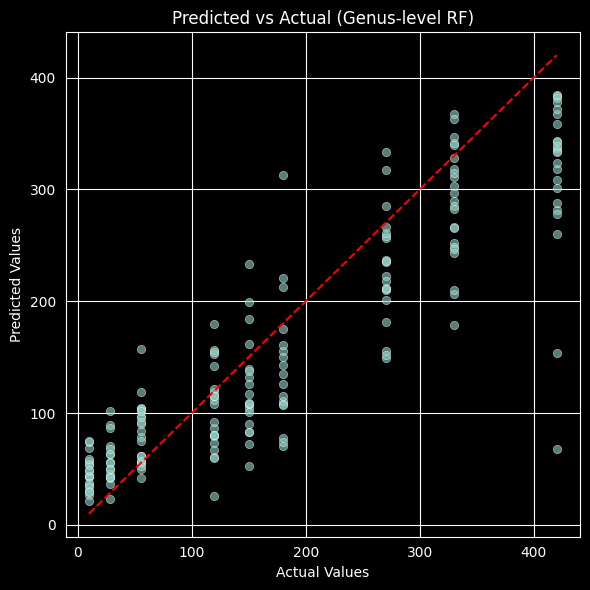

In [102]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_test, y=yhat, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color="red", linestyle="--")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual (Genus-level RF)")
plt.tight_layout()
plt.show()

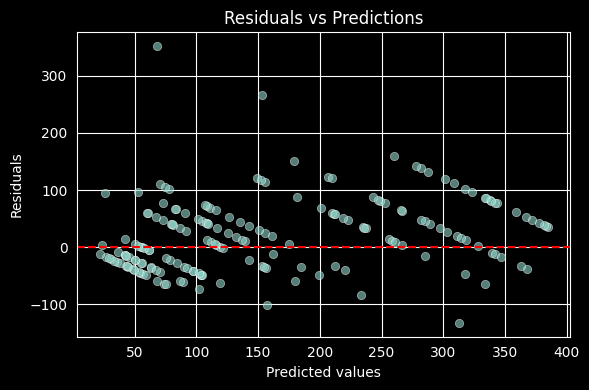

In [103]:
residuals = Y_test - yhat

plt.figure(figsize=(6,4))
sns.scatterplot(x=yhat, y=residuals, alpha=0.6)
plt.axhline(0, linestyle="--", color="red")

plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.tight_layout()
plt.show()

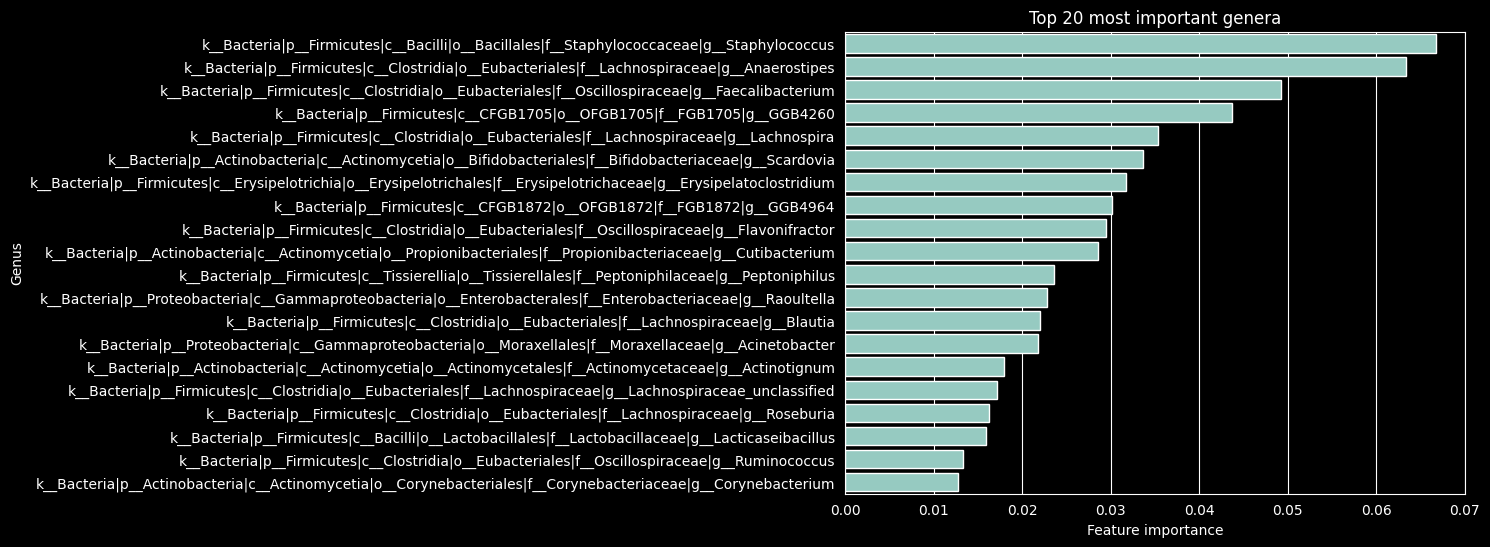

In [104]:
importances = pd.Series(
    best_rf_model.feature_importances_,
    index=X_train_genus.columns
).sort_values(ascending=False)

top_n = 20

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances.head(top_n),
    y=importances.head(top_n).index
)

plt.xlabel("Feature importance")
plt.ylabel("Genus")
plt.title(f"Top {top_n} most important genera")
plt.tight_layout()
plt.show()

In [105]:
st = SuperTree(
    best_rf_model,
    X_train_genus,
    Y_train
)

#st.show_tree(which_tree=0)

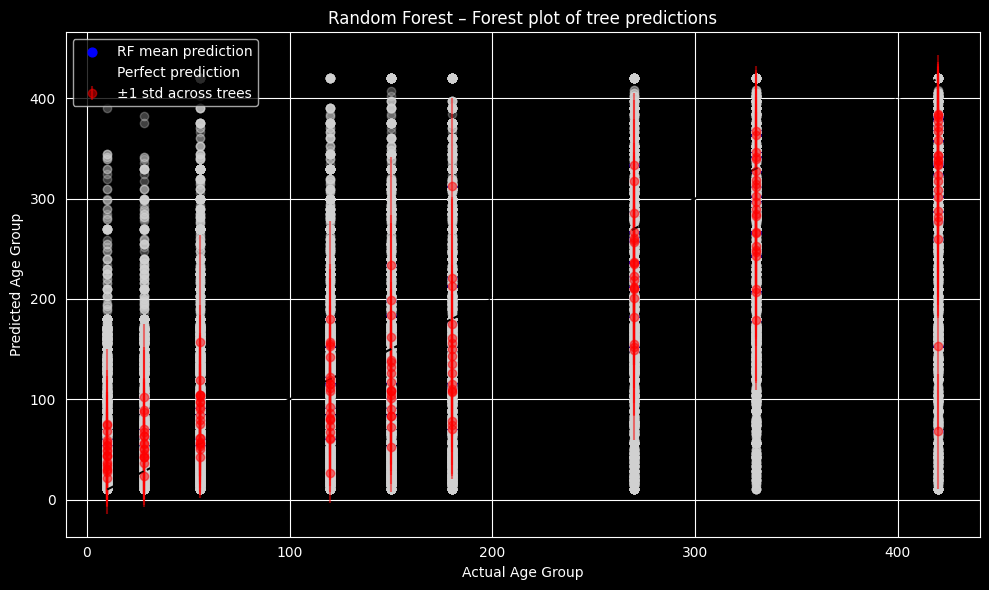

In [106]:
# get predictions from each tree on the test set
all_tree_preds = np.array([tree.predict(X_test_genus) for tree in best_rf_model.estimators_])

# compute the mean prediction (Random Forest final prediction)
rf_pred = all_tree_preds.mean(axis=0)

# compute standard deviation per sample (uncertainty)
rf_std = all_tree_preds.std(axis=0)

plt.figure(figsize=(10,6))

# plot all tree predictions (semi-transparent lines)
for i in range(all_tree_preds.shape[0]):
    plt.plot(Y_test.values, all_tree_preds[i], 'o', color='lightgray', alpha=0.3)

# plot Random Forest mean prediction
plt.scatter(Y_test, rf_pred, color='blue', label='RF mean prediction', s=40)

plt.errorbar(Y_test, rf_pred, yerr=rf_std, fmt='o', color='red', alpha=0.5, label='±1 std across trees')

plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color='black', linestyle='--', label='Perfect prediction')

plt.xlabel("Actual Age Group")
plt.ylabel("Predicted Age Group")
plt.title("Random Forest – Forest plot of tree predictions")
plt.legend()
plt.tight_layout()
plt.show()


# Alternative Models

## XGBoost Alternative

In [107]:
# Base model
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

X_train_clean = X_train_genus.copy()
X_train_clean.columns = [re.sub('[^A-Za-z0-9_]+', '', str(col)) for col in X_train_clean.columns]
X_test_clean = X_test_genus.copy()
X_test_clean.columns = [re.sub('[^A-Za-z0-9_]+', '', str(col)) for col in X_test_clean.columns]


xgb_base.fit(X_train_clean, Y_train)
yhat_xgb = xgb_base.predict(X_test_clean)

print(f"Mean Squared Error: {mean_squared_error(Y_test, yhat_xgb):.3f}")
print(f"Best CV RMSE: {np.sqrt(mean_squared_error(Y_test, yhat_xgb)):.3f}")
print(f"R2 Score: {r2_score(Y_test, yhat_xgb):.3f}")

#Best hyperparameters: {'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.2}

Mean Squared Error: 4589.095
Best CV RMSE: 67.743
R2 Score: 0.754


### Best XGBoost Parameters Search

In [108]:
xgboost_results = xgboost_benchmark(
    X_train_genus,
    X_test_genus,
    Y_train,
    Y_test,
    label="Genus Level"
)
print(f"Best hyperparameters: {xgboost_results.best_params}")

Initializing XGBoost Engine: Genus Level
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Genus Level Complete (33.6s) | R2: 0.798
Best hyperparameters: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.2}


## Additional Ensemble Methods

### AdaBoost

In [109]:
adaboost_results = adaboost_benchmark(
    X_train_genus,
    X_test_genus,
    Y_train,
    Y_test,
    label="Genus Level"
)

print(f"\nBest hyperparameters: {adaboost_results.best_params}")

Initializing AdaBoost Engine: Genus Level
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Genus Level AdaBoost Complete (27.7s) | R2: 0.774

Best hyperparameters: {'n_estimators': 500, 'loss': 'square', 'learning_rate': 1.0}


In [110]:
print(f"Mean Squared Error: {adaboost_results.rmse**2:.3f}")
print(f"Best CV RMSE: {adaboost_results.rmse:.3f}")
print(f"R2 Score: {adaboost_results.r2:.3f}")

best_adaboost_model = adaboost_results.model
yhat_ada = adaboost_results.model.predict(X_test_genus)

Mean Squared Error: 4214.875
Best CV RMSE: 64.922
R2 Score: 0.774


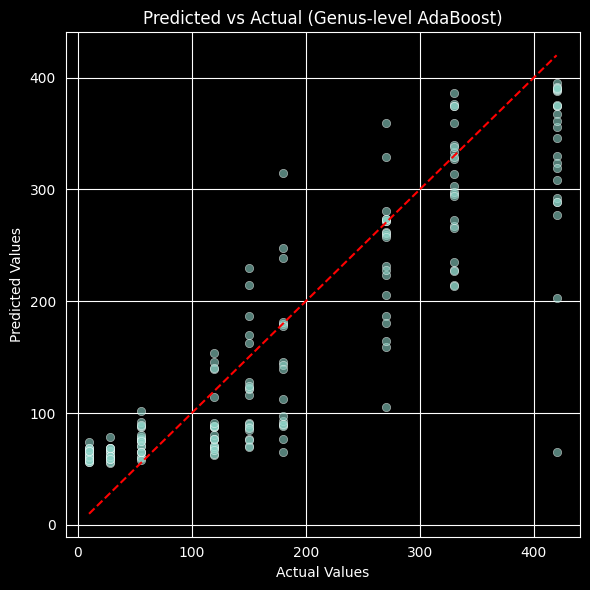

In [111]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_test, y=yhat_ada, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color="red", linestyle="--")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual (Genus-level AdaBoost)")
plt.tight_layout()
plt.show()

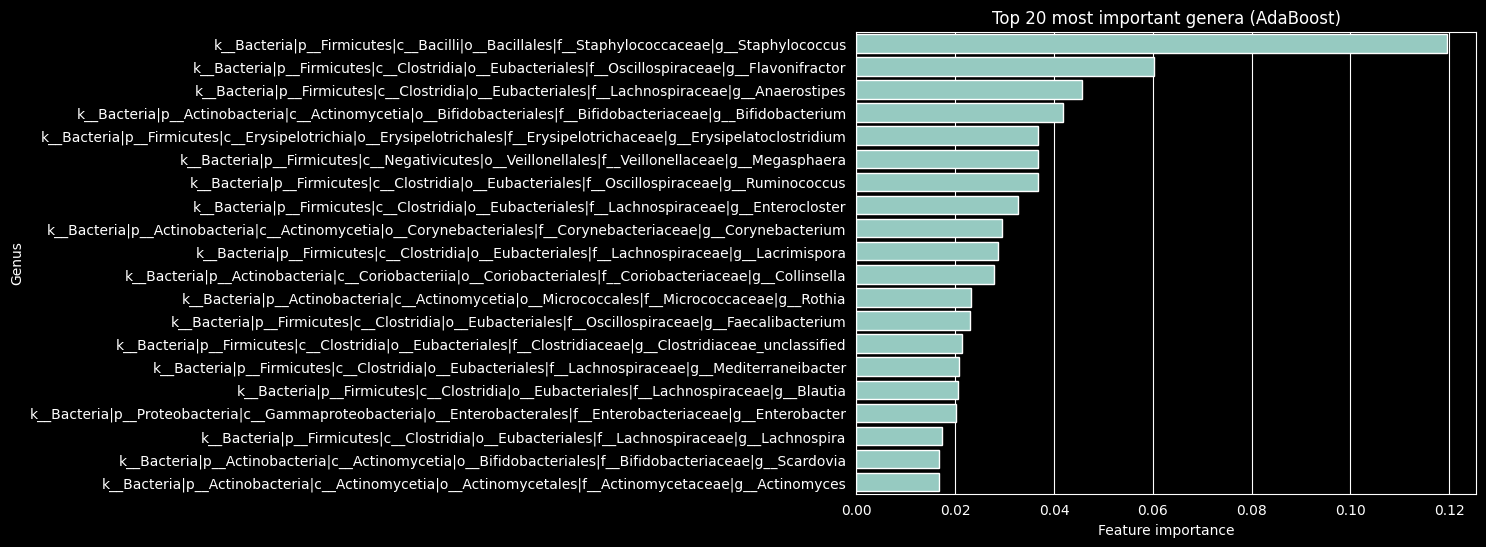

In [112]:
importances_ada = pd.Series(
    best_adaboost_model.feature_importances_,
    index=X_train_genus.columns
).sort_values(ascending=False)

top_n = 20

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances_ada.head(top_n),
    y=importances_ada.head(top_n).index
)

plt.xlabel("Feature importance")
plt.ylabel("Genus")
plt.title(f"Top {top_n} most important genera (AdaBoost)")
plt.tight_layout()
plt.show()

### Gradient Boosting

In [113]:
gb_results = gradient_boosting_benchmark(
    X_train_genus,
    X_test_genus,
    Y_train,
    Y_test,
    label="Genus Level"
)

print(f"\nBest hyperparameters: {gb_results.best_params}")

Initializing Gradient Boosting Engine: Genus Level
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Genus Level Gradient Boosting Complete (9.0s) | R2: 0.797

Best hyperparameters: {'subsample': 0.7, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 50, 'max_features': 'sqrt', 'max_depth': 10, 'learning_rate': 0.05}


In [114]:
print(f"Mean Squared Error: {gb_results.rmse**2:.3f}")
print(f"Best CV RMSE: {gb_results.rmse:.3f}")
print(f"R2 Score: {gb_results.r2:.3f}")

best_gb_model = gb_results.model
yhat_gb = gb_results.model.predict(X_test_genus)

Mean Squared Error: 3796.039
Best CV RMSE: 61.612
R2 Score: 0.797


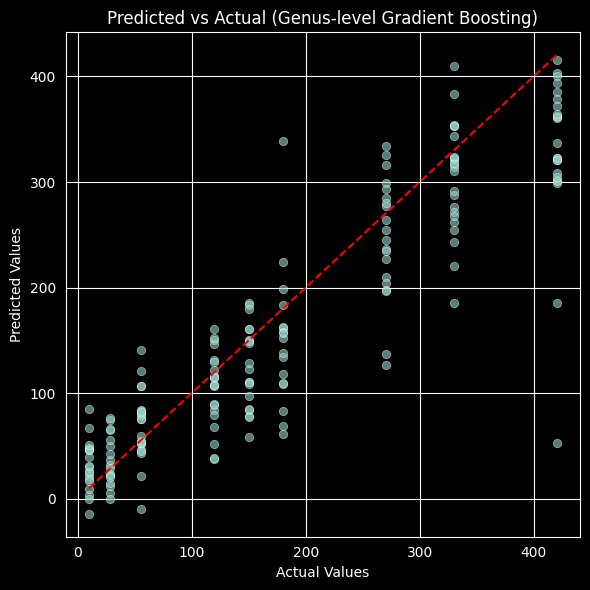

In [115]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_test, y=yhat_gb, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color="red", linestyle="--")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual (Genus-level Gradient Boosting)")
plt.tight_layout()
plt.show()

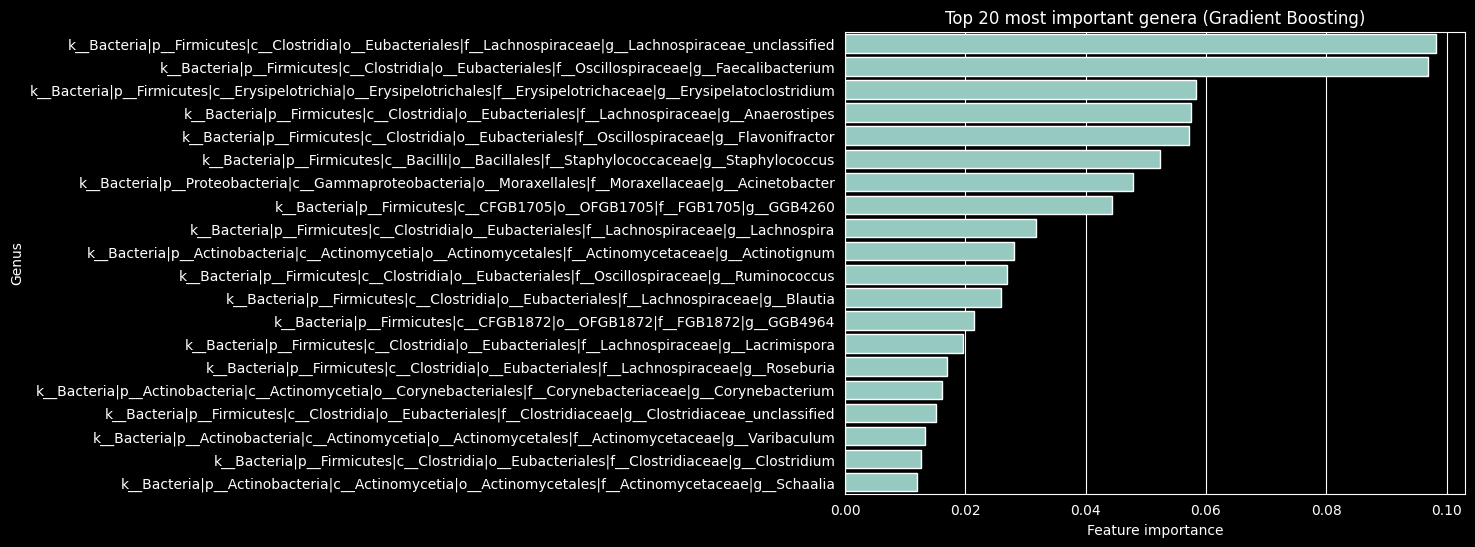

In [116]:
importances_gb = pd.Series(
    best_gb_model.feature_importances_,
    index=X_train_genus.columns
).sort_values(ascending=False)

top_n = 20

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances_gb.head(top_n),
    y=importances_gb.head(top_n).index
)

plt.xlabel("Feature importance")
plt.ylabel("Genus")
plt.title(f"Top {top_n} most important genera (Gradient Boosting)")
plt.tight_layout()
plt.show()

### LightGBM

In [117]:
lgb_results = lightgbm_benchmark(
    X_train_genus,
    X_test_genus,
    Y_train,
    Y_test,
    label="Genus Level"
)

print(f"\nBest hyperparameters: {lgb_results.best_params}")

Initializing LightGBM Engine: Genus Level
Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

In [ ]:
print(f"Mean Squared Error: {lgb_results.rmse**2:.3f}")
print(f"Best CV RMSE: {lgb_results.rmse:.3f}")
print(f"R2 Score: {lgb_results.r2:.3f}")

best_lgb_model = lgb_results.model
yhat_lgb = lgb_results.model.predict(X_test_genus)

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_test, y=yhat_lgb, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color="red", linestyle="--")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual (Genus-level LightGBM)")
plt.tight_layout()
plt.show()

In [ ]:
importances_lgb = pd.Series(
    best_lgb_model.feature_importances_,
    index=X_train_genus.columns
).sort_values(ascending=False)

top_n = 20

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances_lgb.head(top_n),
    y=importances_lgb.head(top_n).index
)

plt.xlabel("Feature importance")
plt.ylabel("Genus")
plt.title(f"Top {top_n} most important genera (LightGBM)")
plt.tight_layout()
plt.show()

## Model Interpretability with LIME and SHAP

### LIME (Local Interpretable Model-agnostic Explanations)

In [ ]:
# Use the Random Forest model for explanation
lime_explanations = explain_with_lime(
    model=best_rf_model,
    X_train=X_train_genus,
    X_test=X_test_genus,
    feature_names=X_train_genus.columns.tolist(),
    num_samples=3,
    num_features=10
)

print("LIME Explanations for Random Forest Model:")
print(f"Number of samples explained: {len(lime_explanations)}")

In [ ]:
# Quick check
print(type(lime_explanations))
print(list(lime_explanations.keys())[:5])  # first 5 keys

# Check one element
sample_idx = list(lime_explanations.keys())[0]
print(lime_explanations[sample_idx])

In [ ]:
for sample_idx, explanation in lime_explanations.items():
    print(f"\n{'='*80}")
    print(f"Sample {sample_idx}:")
    print(f"Predicted value: {explanation['prediction']:.3f}")
    # actual value is not returned by LIME, so get it from Y_test or elsewhere
    print(f"Actual value: {Y_test.iloc[int(sample_idx.split('_')[1])]:.3f}")
    print(f"\nTop contributing features:")
    for feature, weight in explanation['explanation'][:10]:
        print(f"  {feature}: {weight:+.4f}")

In [ ]:
# Display explanation for first sample
#for sample_idx, explanation in lime_explanations.items():
#    print(f"\n{'='*80}")
#    print(f"Sample {sample_idx}:")
#   print(f"Predicted value: {explanation['predicted_value']:.3f}")
#    print(f"Actual value: {explanation['actual_value']:.3f}")
#    print(f"\nTop contributing features:")
#    for feature, weight in explanation['explanation'][:10]:
#        print(f"  {feature}: {weight:+.4f}")

### SHAP (SHapley Additive exPlanations)

In [ ]:
# Use the Random Forest model for SHAP explanation
shap_result = explain_with_shap(
    model=best_rf_model,
    X_train=X_train_genus,
    X_test=X_test_genus,
    feature_names=X_train_genus.columns.tolist(),
    background_samples=100
)

print("SHAP Analysis Complete")
print(f"SHAP values shape: {shap_result['shap_values'].shape}")

In [ ]:
import shap

# Summary plot showing feature importance
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_result['shap_values'],
    X_test_genus,
    feature_names=X_train_genus.columns.tolist(),
    max_display=20,
    show=False
)
plt.tight_layout()
plt.show()

In [ ]:
# Bar plot of mean absolute SHAP values
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_result['shap_values'],
    X_test_genus,
    feature_names=X_train_genus.columns.tolist(),
    plot_type="bar",
    max_display=20,
    show=False
)
plt.tight_layout()
plt.show()

# Feature Selection via neural networks

## The finding

In [ ]:
if RUN_NN:
    nn_res = nn_feature_search(X_train, X_test, Y_train)

    if nn_res:
        elite_bacteria_list = nn_res.feature_names
        print(f"Selected {nn_res.n_features} elite bacterial drivers.")
        print(f"Expected Validation RMSE: {nn_res.rmse:.2f} days")
    else:
        print("No feature set found within the target range.")

## Comparing the genus vs neural network features on all models

# Feature Cutoff Cross-Validation

Test model performance at different taxonomic levels

In [ ]:
# Test Random Forest at different taxonomic levels
rf_cutoff_results = cross_validate_feature_cutoffs(
    X_train_raw,
    Y_train,
    feature_levels=['Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'],
    model_type='RandomForest',
    cv_folds=5
)

In [ ]:
# Visualize the results
plot_feature_cutoff_comparison(rf_cutoff_results, title="Random Forest Performance")

## Compare Different Models Across Taxonomic Levels

In [ ]:
# Test other models
xgb_cutoff_results = cross_validate_feature_cutoffs(
    X_train_raw,
    Y_train,
    feature_levels=['Phylum', 'Class', 'Order', 'Family', 'Genus'],
    model_type='XGBoost',
    cv_folds=5
)

In [ ]:
lgbm_cutoff_results = cross_validate_feature_cutoffs(
    X_train_raw,
    Y_train,
    feature_levels=['Phylum', 'Class', 'Order', 'Family', 'Genus'],
    model_type='LightGBM',
    cv_folds=5
)

# Advanced Model Visualizations

In [ ]:
# Residuals analysis for best Random Forest model
plot_residuals_analysis(Y_test, yhat, title="Random Forest Residuals Analysis")

In [ ]:
# Prediction intervals (showing uncertainty from individual trees)
plot_prediction_intervals(
    Y_test, 
    yhat,
    prediction_std=rf_std,
    sample_indices=range(50),  # Show first 50 samples
    title="Random Forest Predictions with Uncertainty"
)

In [ ]:
# Learning curves to check for overfitting

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
plot_learning_curves(
    rf_model,
    X_train_genus,
    Y_train,
    cv_folds=5,
    title="Random Forest Learning Curves (Genus Level)"
)

## Model Comparison

In [ ]:
# Compare all models (assuming they've been run)
try:
    model_results = {
        'Random Forest': rf_results,
        'AdaBoost': adaboost_results,
        'Gradient Boosting': gb_results,
        'LightGBM': lgb_results
    }
    plot_model_comparison_heatmap(model_results, title="Model Performance Comparison")
except NameError:
    print("Some models haven't been run yet. Run all benchmark functions first.")

In [ ]:
try:
    nn_res
except NameError:
    print("Neural network did not run")
else:
        feature_sets = {
        "Genus Level": X_train_genus,
        "NN Level": nn_res.X_train_elite
    }
        battle_stats = final_battle(feature_sets, Y_train)